In [2]:
import json
import pickle
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use('ggplot')
#plt.rcParams["figure.figsize"] = (20,3)

In [3]:
data_path = './scidocs/data/'
paper_cite_file = data_path + 'paper_metadata_view_cite_read.json'
paper_cls_file = data_path + 'paper_metadata_mag_mesh.json'
paper_rec_file = data_path + 'paper_metadata_recomm.json'
user_activity_and_citations_embeddings_path = data_path + 'specter-embeddings/user-citation.jsonl'

## Look at the data

In [4]:
papers_data = {}
with open(paper_rec_file, 'r') as f:
    papers_data = json.load(f)

In [5]:
list(list(papers_data.values())[0].keys())

['abstract', 'authors', 'cited_by', 'paper_id', 'references', 'title', 'year']

In [6]:
papers_df = pd.DataFrame(papers_data).T

In [7]:
#extra column
all(papers_df.index == papers_df.paper_id)

True

In [8]:
papers_df.shape

(36261, 7)

## Create graph

In [9]:
G = nx.DiGraph()
G.add_nodes_from(papers_data.keys())

In [10]:
for paper_id, paper_attrs in papers_data.items():
    for citing_id in paper_attrs['cited_by']:
        if citing_id in G:
            G.add_edge(citing_id, paper_id)
    for cited_id in paper_attrs['references']:
        if cited_id in G:
            G.add_edge(paper_id, cited_id)

In [11]:
len(G)

36261

# Find the most connected node and create a subgraph from the nodes connected to it

## Find the nodes degrees

In [12]:
conn_comp_sizes = []
for c in nx.weakly_connected_components(G):
    conn_comp_sizes.append(len(c))

In [13]:
sorted(conn_comp_sizes, reverse=True)[:10]

[4716, 187, 111, 97, 93, 84, 61, 56, 55, 46]

## Create a dictionary where key is the degree of the node and value is nodes connected to it

In [14]:
conn_comps = {len(c):c for c in nx.weakly_connected_components(G)}

## Get the node with the biggest degree (most connected one) 

In [15]:
largest_conn_comp = conn_comps[max(conn_comps.keys())]

In [16]:
len(largest_conn_comp)

4716

In [17]:
for count, node_id in enumerate(largest_conn_comp):
    print(node_id)
    if count > 4:
        break

02a5079589922dcb7a947384e6f4c77aa2bddac2
e64c0ddf3e08f97b5ed7de81e4dfb71948f70d2d
03b84b789cb342587db621c7e88eeb005cc21578
5c6dd659e471127ed99e923bfd8c097cd457e2b4
b8540087fc737803d30876357022cafb6056924c
5e00690a17efa9bd63e5b6cc19a7462d6d152ea0


## Create a subgraph from the nodes connected to it

In [18]:
Glcc = G.subgraph(largest_conn_comp)

In [19]:
len(Glcc)

4716

In [20]:
#combine previous cells into functions
def get_graph(file_name):
    papers_data = {}
    with open(file_name, 'r') as f:
        papers_data = json.loads(f.read())
    G = nx.DiGraph()
    G.add_nodes_from(papers_data.keys())
    for paper_id, paper_attrs in papers_data.items():
        for citing_id in paper_attrs['cited_by']:
            if citing_id in G:
                G.add_edge(citing_id, paper_id)
        for cited_id in paper_attrs['references']:
            if cited_id in G:
                G.add_edge(paper_id, cited_id)
    return G

def get_LCC(G):
    conn_comps = {len(c):c for c in nx.weakly_connected_components(G)}
    largest_conn_comp = conn_comps[max(conn_comps.keys())]
    Glcc = G.subgraph(largest_conn_comp)
    return Glcc.copy()

In [21]:
G = get_graph(paper_rec_file)
G = get_LCC(G)

In [22]:
len(G)

4716

# Add embedding as a node attribute

## Download embeddings

In [23]:
def load_embeddings_from_jsonl(embeddings_path, G):
    embeddings = {}
    with open(embeddings_path, 'r') as f:
        for line in tqdm(f, desc='reading embeddings from file...'):
            line_json = json.loads(line)
            if line_json['paper_id'] in G:
                embeddings[line_json['paper_id']] = np.array(line_json['embedding'], dtype=np.float32)
    return embeddings

embeddings = load_embeddings_from_jsonl(user_activity_and_citations_embeddings_path, G)

reading embeddings from file...: 142009it [00:36, 3900.32it/s]


## Amount of resourses with embeddings

In [24]:
len(embeddings.keys())

964

## Create a subgraph based on resourses with embs

In [25]:
Grec = get_LCC(G.subgraph(embeddings.keys()))
nx.set_node_attributes(Grec, {node_id: {"x":embedding} for node_id, embedding in embeddings.items()})

In [26]:
len(Grec), len(Grec.edges), len(embeddings)

(419, 679, 964)

# Updload the final graph

In [27]:
with open(data_path + 'rec_graph.pkl', 'wb') as f:
    pickle.dump(Grec, f)

# Link prediction

## Import libraries

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric
import torch_geometric.utils
from torch_geometric.utils import from_networkx

## Create LinkPredictionModel class

In [29]:
class LinkPredictionModel(torch.nn.Module):

    def __init__(self, layer_type, sz_in, num_layers=2, sz_hid=128, sz_out=64):
        super().__init__()

        # GNN layers with ReLU
        encoder = []
        encoder.append(layer_type(sz_in, sz_hid))
        encoder.append(nn.ReLU())
        for _ in range(num_layers-2):
            encoder.append(layer_type(sz_hid, sz_hid))
            encoder.append(nn.ReLU())
        encoder.append(layer_type(sz_hid, sz_out))
        self.encoder = nn.ModuleList(encoder)
    
    # Encoding: usual GNN propagation
    def encode(self, fts, adj):
        for l in self.encoder:
            if isinstance(l, nn.ReLU):
                fts = l(fts)
            else:
                fts = l(fts, adj)
        return fts
    
    # Decoding: dot(H[i], H[j]) for each edge in edge_index
    # Larger dot => the model is more confident that this edge should exist
    def decode(self, H, edge_index):
        return (H[edge_index[0]] * H[edge_index[1]]).sum(dim=1)

## Train validation test split

In [30]:
from torch_geometric.utils import train_test_split_edges

data = from_networkx(Grec)
data.train_mask = data.val_mask = data.test_mask = data.y = None
print(data)

data = train_test_split_edges(data, 0.2, 0.2)
print(data.x)
print(data)
print()
print(f'Train set: {data.train_pos_edge_index.shape[1]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {data.val_pos_edge_index.shape[1]} positive edges, {data.val_neg_edge_index.shape[1]} negative edges')
print(f'Test set: {data.test_pos_edge_index.shape[1]} positive edges, {data.test_neg_edge_index.shape[1]} negative edges')

Data(x=[419, 768], edge_index=[2, 679])
tensor([[-3.9596,  0.6370, -2.9044,  ..., -2.0378, -0.6038, -0.9319],
        [ 1.5410, -3.0462, -0.0496,  ...,  0.0902, -1.8819, -5.2567],
        [-4.1549, -4.7426, -0.2539,  ...,  2.1619,  2.4108, -2.9084],
        ...,
        [-5.0677, -1.2293, -0.8887,  ...,  2.1283,  0.2426,  0.7622],
        [-1.4548, -2.9606, -1.6335,  ...,  1.7059, -4.0190, -1.0405],
        [-5.2130, -4.3919, -1.7544,  ..., -0.4056, -3.3897,  0.7571]])
Data(x=[419, 768], val_pos_edge_index=[2, 74], test_pos_edge_index=[2, 74], train_pos_edge_index=[2, 452], train_neg_adj_mask=[419, 419], val_neg_edge_index=[2, 74], test_neg_edge_index=[2, 74])

Train set: 452 positive edges, we will sample the same number of negative edges at runtime
Val set: 74 positive edges, 74 negative edges
Test set: 74 positive edges, 74 negative edges


e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)
e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


## Utility functions

In [105]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.gridspec import GridSpec
 

# A utility function to compute the ROC-AUC score on given edges
def get_roc_auc(model, data, edge_index, labels):
    with torch.no_grad():
        H = model.encode(data.x, data.train_pos_edge_index)
        z = model.decode(H, edge_index)
        s = z.sigmoid()
        return roc_auc_score(labels, s)
    
# A utility function to compute the F1-score on given edges
def get_f1_score(model, data, edge_index, labels):
    with torch.no_grad():
        H = model.encode(data.x, data.train_pos_edge_index)
        z = model.decode(H, edge_index)
        s = z.sigmoid().numpy() >= 0.5
        return f1_score(labels, s)
    
# A utility function to compute the confusion matrix on given edges
def get_confusion_matrix(model, data, edge_index, labels):
    with torch.no_grad():
        H = model.encode(data.x, data.train_pos_edge_index)
        z = model.decode(H, edge_index)
        s = z.sigmoid().numpy() >= 0.5
        return confusion_matrix(labels, s) 
    
# A utility function to plot all metrics
def plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 2, figure=fig)
    #f, axes = plt.subplots(2,2, figsize=figsize)

    # create sub plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    ax4 = fig.add_subplot(gs[2, :])
    
    # Plot loss for 10 epochs
    ax1.set_title('Loss 10 epoch')
    ax1.plot(np.arange(10)+1, loss_all[:10])
    ax1.set_xlabel('Epoch')
    
    # Plot loss for remaining epochs
    ax2.set_title('Loss after 10 epochs')
    ax2.plot(np.arange(10, num_epochs)+1, loss_all[10:])
    ax2.set_xlabel('Epoch')

    # # Plot ROC AUC for 5 epochs
    # axes[1,0].set_title('ROC AUC Scores')
    # axes[1,0].plot(np.arange(5)+1, auc_val_all[:5], label='Validation ROC', alpha=0.8)
    # axes[1,0].plot(np.arange(5)+1, auc_test_all[:5], label='Test ROC', alpha=0.8)
    # axes[1,0].set_xlabel('Epoch')
    # axes[1,0].legend()
    
    # Plot ROC AUC for remaining epochs
    ax3.set_title('ROC AUC Scores')
    ax3.plot(np.arange(num_epochs)+1, auc_val_all, label='ROC Validation', alpha=0.8)
    ax3.plot(np.arange(num_epochs)+1, auc_test_all, label='ROC Test', alpha=0.8)
    ax3.set_xlabel('Epoch')
    ax3.legend()

    # Plot ROC AUC for remaining epochs
    ax4.set_title('F1-Scores')
    ax4.plot(np.arange(num_epochs)+1, f1_val_all, label='F1 Validation', alpha=0.8)
    ax4.plot(np.arange(num_epochs)+1, f1_test_all, label='F1 Test', alpha=0.8)
    ax4.set_xlabel('Epoch')
    ax4.legend()

    fig.tight_layout()

def display_cms(cm_val, cm_test, title1, title2, figsize=(5,3)):
    f, axes = plt.subplots(1,2, figsize=figsize)
    axes[0].set_title(title1, fontsize=10)
    axes[0].grid(False)
    ConfusionMatrixDisplay(cm_val).plot(colorbar=False, ax=axes[0])
    axes[1].set_title(title2, fontsize=10)
    axes[1].grid(False)
    ConfusionMatrixDisplay(cm_test).plot(colorbar=False, ax=axes[1])
    f.tight_layout()
    plt.show()

## Define training function

In [108]:
from torch_geometric.utils import negative_sampling

# Train the given model on the given dataset for num_epochs
def train(model, data, num_epochs):
    # Metrics
    loss_all = []
    auc_val_all = []
    auc_test_all = []
    f1_val_all = []
    f1_test_all = []
    
    # Set up the loss and the optimizer
    loss_fn = nn.BCEWithLogitsLoss() # Binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare all edges/labels for val/test
    val_pos, val_neg = data.val_pos_edge_index, data.val_neg_edge_index
    val_edge_index = torch.cat([val_pos, val_neg], dim=1)
    val_labels = torch.cat([torch.ones(val_pos.shape[1]), torch.zeros(val_neg.shape[1])])
    
    test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
    test_edge_index = torch.cat([test_pos, test_neg], dim=1)
    test_labels = torch.cat([torch.ones(test_pos.shape[1]), torch.zeros(test_neg.shape[1])])

    auc_val_best = -1
    for epoch in range(num_epochs):
        # Sample negative edges
        pos_edge_index = data.train_pos_edge_index # T_+
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index, # edges to ignore
            num_nodes=data.num_nodes, # N
            num_neg_samples=pos_edge_index.shape[1] # number of edges to sample
        )
    
        # Zero grads -> encode to get node latents
        optimizer.zero_grad()
        H = model.encode(data.x, pos_edge_index)

        # Decode to get a score for all (positive and negative) edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        z = model.decode(H, edge_index)

        # Construct the label vector and backprop the loss
        labels = torch.cat([torch.ones(pos_edge_index.shape[1]), torch.zeros(neg_edge_index.shape[1])])
        
        loss = loss_fn(z, labels)
        loss.backward()
        optimizer.step()

        # Compute ROC AUC and conf. matrices
        auc_val = get_roc_auc(model, data, val_edge_index, val_labels)
        f1_val = get_f1_score(model, data, val_edge_index, val_labels)
        cm_val = get_confusion_matrix(model, data, val_edge_index, val_labels)
        auc_test = get_roc_auc(model, data, test_edge_index, test_labels)
        f1_test = get_f1_score(model, data, test_edge_index, test_labels)
        cm_test = get_confusion_matrix(model, data, test_edge_index, test_labels)
        auc_val_all.append(auc_val)
        auc_test_all.append(auc_test)
        f1_val_all.append(f1_val)
        f1_test_all.append(f1_test)
        loss_all.append(loss.detach().numpy())
        
        # Print every 100 epochs
        if (epoch+1) % 100 == 0:
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.12f} | AUC Val : {auc_val:.3f} | AUC Test: {auc_test:.3f}')
            print(f'                                    | F1 Val : {f1_val:.3f} | F1 Test: {f1_test:.3f}\n')
            display_cms(cm_val, cm_test,
                         title1=f'Ep {epoch+1} val confusion matrix',
                         title2=f'Ep {epoch+1} test confusion matrix'
                         )

        # Print when best val score achieved
        if auc_val > auc_val_best:
            auc_val_best = auc_val
            f1_val_best = f1_val
            cm_val_best = cm_val
            epoch_best = epoch+1
            auc_test_best = auc_test
            f1_test_best = f1_test
            cm_test_best = cm_test
            loss_best = loss
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.12f} | AUC Val: {auc_val:.3f} | AUC Test: {auc_test:.3f}')
            print(f'                                    | F1 Val : {f1_val:.3f} | F1 Test: {f1_test:.3f}\n')
            
    print(f'\nThe best epoch: {epoch_best} Loss: {loss_best:.12f} | AUC Val: {auc_val_best:.3f} | AUC Test: {auc_test_best:.3f}')
    print(f'                                         | F1 Val : {f1_val_best:.3f} | F1 Test: {f1_test_best:.3f}')
    display_cms(cm_val_best, cm_test_best,
                         title1='Best ep val confusion matrix',
                         title2='Best ep test confusion matrix'
                         )


    
    # Plot
    plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all)

## Model training

### 2-layer GCN, hidden=128, output=64

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 128)
    (1): ReLU()
    (2): GCNConv(128, 64)
  )
)
[Epoch 1/100] Loss: 182.049606323242 | AUC Val: 0.527 | AUC Test: 0.507
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 54.401721954346 | AUC Val: 0.607 | AUC Test: 0.601
                                    | F1 Val : 0.699 | F1 Test: 0.692

[Epoch 3/100] Loss: 21.883573532104 | AUC Val: 0.660 | AUC Test: 0.662
                                    | F1 Val : 0.695 | F1 Test: 0.692

[Epoch 6/100] Loss: 14.767520904541 | AUC Val: 0.727 | AUC Test: 0.723
                                    | F1 Val : 0.709 | F1 Test: 0.708

[Epoch 7/100] Loss: 10.814231872559 | AUC Val: 0.776 | AUC Test: 0.817
                                    | F1 Val : 0.702 | F1 Test: 0.715

[Epoch 8/100] Loss: 7.858547687531 | AUC Val: 0.818 | AUC Test: 0.844
                                    | F1 Val : 0.716 | F1 Test: 0.729

[Epoch 9/100] Loss: 5.51595

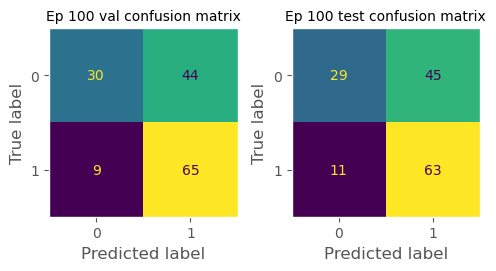


The best epoch: 10 Loss: 4.222553730011 | AUC Val: 0.897 | AUC Test: 0.818
                                         | F1 Val : 0.737 | F1 Test: 0.727


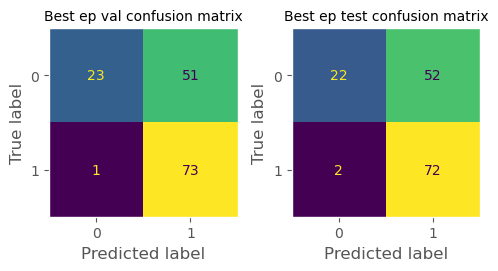

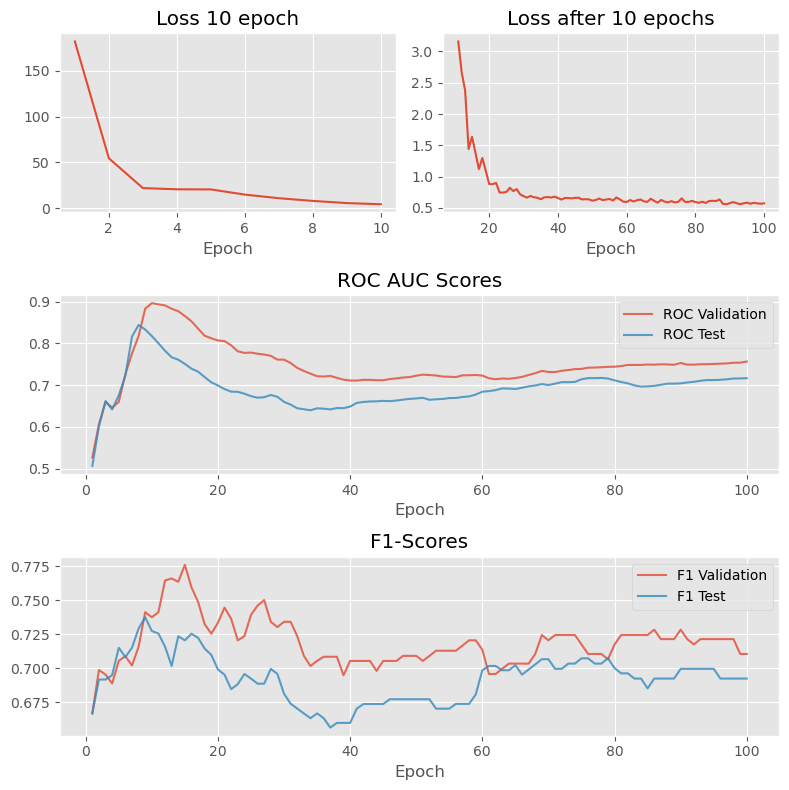

In [109]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv, data.x.shape[1])
print(model)
train(model, data, num_epochs=100) # AUC Val: 0.871 | AUC Test: 0.818 | F1 Val : 0.756 | F1 Test: 0.741

### 2-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 298.117706298828 | AUC Val: 0.500 | AUC Test: 0.500
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 85.362091064453 | AUC Val: 0.628 | AUC Test: 0.601
                                    | F1 Val : 0.689 | F1 Test: 0.682

[Epoch 3/100] Loss: 28.085287094116 | AUC Val: 0.649 | AUC Test: 0.568
                                    | F1 Val : 0.705 | F1 Test: 0.685

[Epoch 5/100] Loss: 25.912765502930 | AUC Val: 0.661 | AUC Test: 0.615
                                    | F1 Val : 0.692 | F1 Test: 0.682

[Epoch 6/100] Loss: 18.017446517944 | AUC Val: 0.761 | AUC Test: 0.667
                                    | F1 Val : 0.709 | F1 Test: 0.698

[Epoch 7/100] Loss: 11.109591484070 | AUC Val: 0.832 | AUC Test: 0.783
                                    | F1 Val : 0.723 | F1 Test: 0.715

[Epoch 8/100] Loss: 8.077

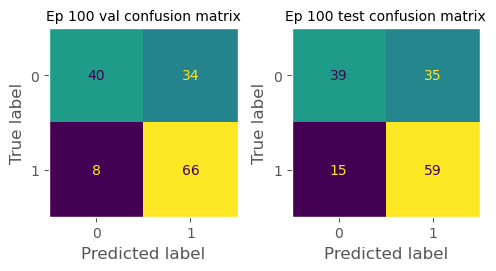


The best epoch: 10 Loss: 4.083104133606 | AUC Val: 0.890 | AUC Test: 0.826
                                         | F1 Val : 0.756 | F1 Test: 0.722


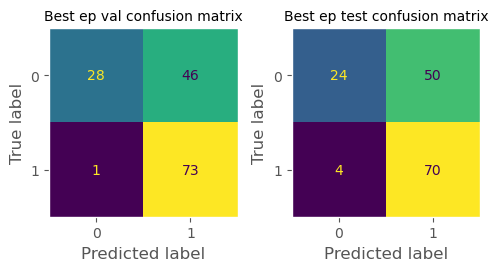

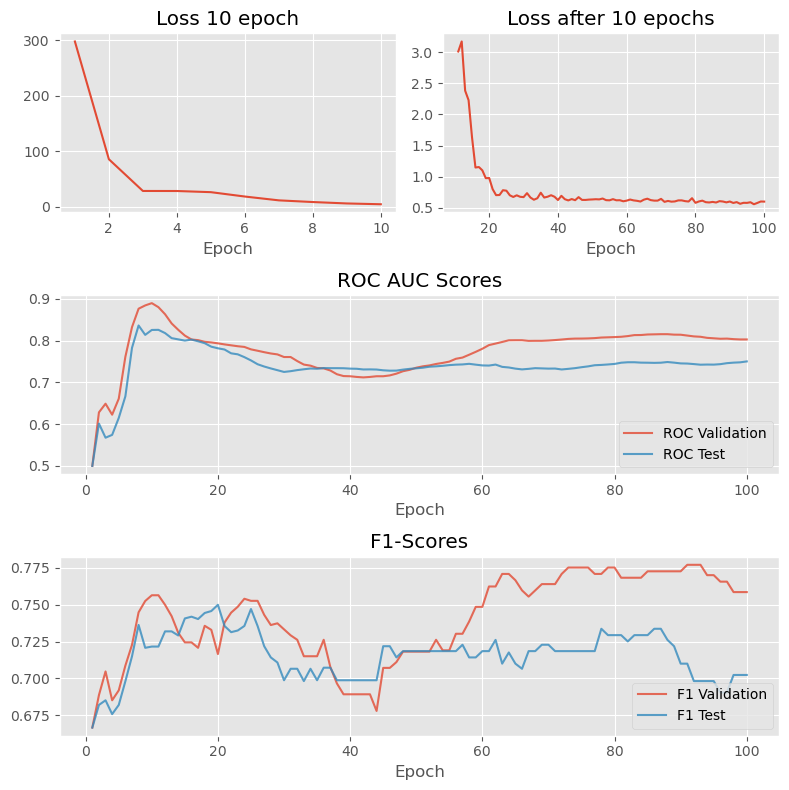

In [110]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100) # Val: 0.895 | Test: 0.831

### 3-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 123.155708312988 | AUC Val: 0.554 | AUC Test: 0.541
                                    | F1 Val : 0.679 | F1 Test: 0.673

[Epoch 2/100] Loss: 21.432369232178 | AUC Val: 0.610 | AUC Test: 0.635
                                    | F1 Val : 0.682 | F1 Test: 0.682

[Epoch 3/100] Loss: 13.548925399780 | AUC Val: 0.668 | AUC Test: 0.689
                                    | F1 Val : 0.685 | F1 Test: 0.682

[Epoch 4/100] Loss: 11.070858955383 | AUC Val: 0.806 | AUC Test: 0.775
                                    | F1 Val : 0.688 | F1 Test: 0.685

[Epoch 5/100] Loss: 6.860040664673 | AUC Val: 0.856 | AUC Test: 0.785
                                    | F1 Val : 0.692 | F1 Test: 0.685

[Epoch 6/100] Loss: 5.240425109863 | AUC Val: 0.867 | AUC Test: 0.811
                                    | F1 Val : 0.695 | 

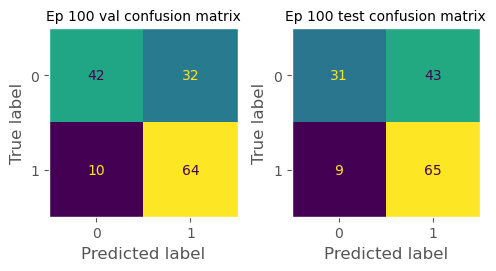


The best epoch: 8 Loss: 3.474627494812 | AUC Val: 0.929 | AUC Test: 0.875
                                         | F1 Val : 0.712 | F1 Test: 0.692


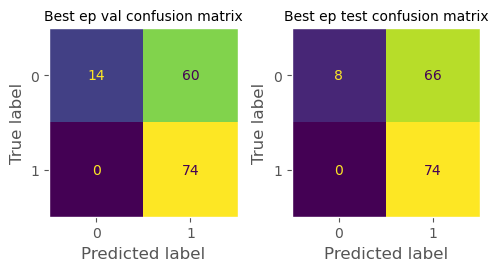

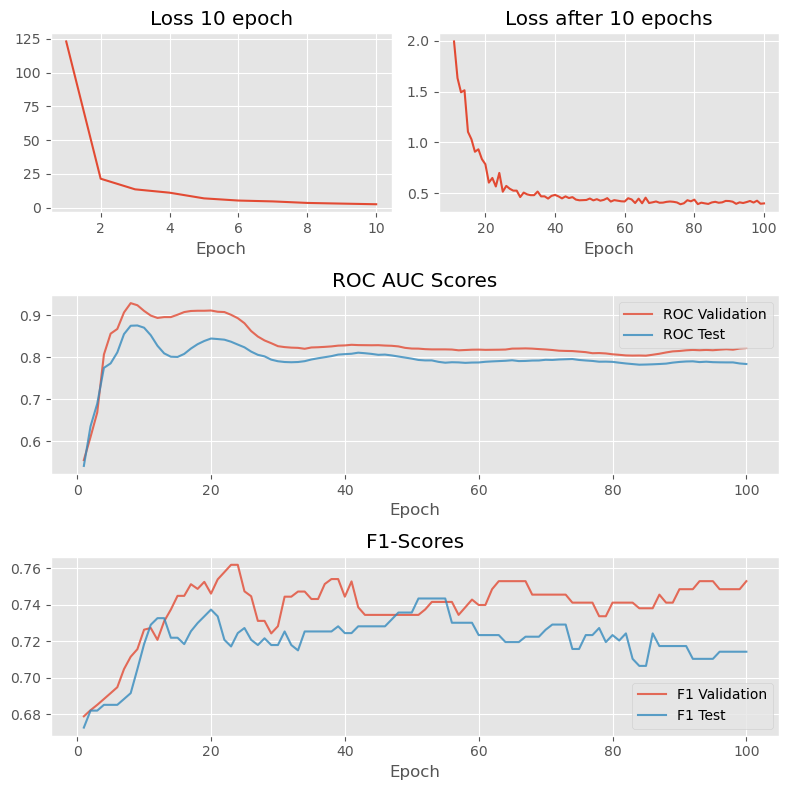

In [111]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=3,
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100) # | AUC Val: 0.929 | AUC Test: 0.875 | F1 Val : 0.712 | F1 Test: 0.692

### 4-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 256)
    (5): ReLU()
    (6): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 109.149559020996 | AUC Val: 0.527 | AUC Test: 0.527
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 16.573226928711 | AUC Val: 0.789 | AUC Test: 0.738
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 3/100] Loss: 7.673190593719 | AUC Val: 0.892 | AUC Test: 0.842
                                    | F1 Val : 0.670 | F1 Test: 0.679

[Epoch 4/100] Loss: 4.590779781342 | AUC Val: 0.906 | AUC Test: 0.885
                                    | F1 Val : 0.676 | F1 Test: 0.695

[Epoch 5/100] Loss: 2.604981660843 | AUC Val: 0.916 | AUC Test: 0.904
                                    | F1 Val : 0.688 | F1 Test: 0.692

[Epoch 6/100] Loss: 1.819682598114 | AUC Val: 0.924 | AUC Test: 0.894
              

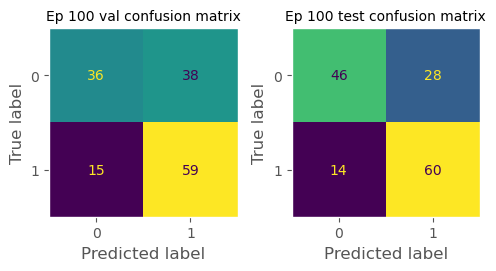


The best epoch: 6 Loss: 1.819682598114 | AUC Val: 0.924 | AUC Test: 0.894
                                         | F1 Val : 0.685 | F1 Test: 0.695


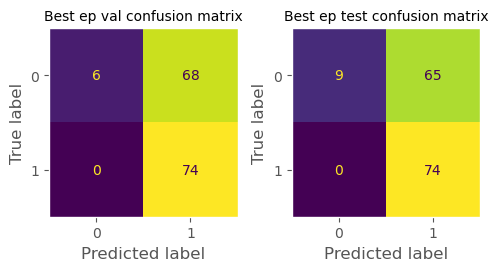

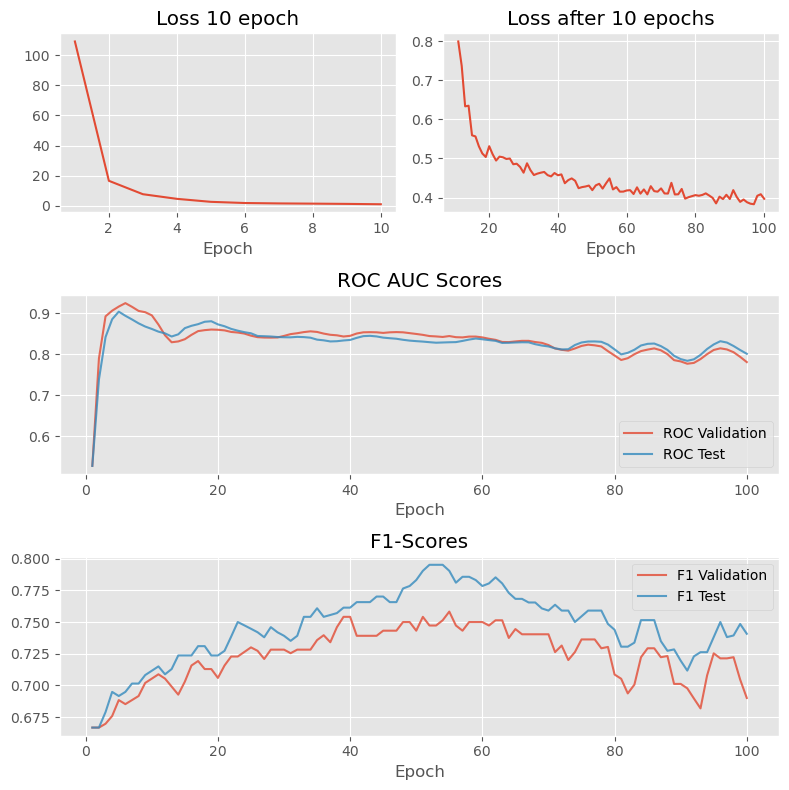

In [112]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=4,
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100) # | AUC Val: 0.924 | AUC Test: 0.894 | F1 Val : 0.685 | F1 Test: 0.695